In [1]:
pip install lxml;

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install beautifulsoup4

Note: you may need to restart the kernel to use updated packages.


## Парсинг сайта "Кинопоиск"

In [1]:
import lxml
import re
import requests
from bs4 import BeautifulSoup

to_string = ''

max_page = 1
pages = []

url = 'https://www.kinopoisk.ru/lists/top250/'
pages = requests.get(url)
soup = BeautifulSoup(pages.content, 'html.parser')

nazvanie = soup.findAll('p', attrs={'class':"selection-film-item-meta__name"})
country = soup.findAll('span', attrs={'class': "selection-film-item-meta__meta-additional-item"})
ratings = soup.findAll('span', attrs={'class': "rating__value rating__value_positive"})

## Формирование данных для записи в бд

In [2]:
for i in range(len(nazvanie)):
    nazvanie[i] = re.sub('[^а-яА-ЯёЁ0-9+-,:]+', ' ', str(nazvanie[i]))
for i in range(len(country)):
    country[i] = re.sub('[^а-яА-Я,]+', ' ', str(country[i]))

In [3]:
ratings_list = []
for i in range(len(ratings)):
    ratings[i] = str(ratings[i])
    ratings[i] = ratings[i].replace('<span class="rating__value rating__value_positive" data-tid="59e7b831">', '').replace('</span>','')
    ratings_list.append(ratings[i])

In [4]:
genre = []
for i in range(len(country)):
    if i % 2 == 0:
        genre.append(country[i+1])

In [5]:
strana = []
for i in range(len(country)):
    if i % 2 != 0:
        strana.append(country[i-1])

In [6]:
genre_1 = []
for i in range(len(genre)):    
    a = genre[i].find(',')
    b = len(genre[i])
    genre_2 = [genre[i][1:a]]
    genre_1.append(genre_2)
    genre_2 = []
    

In [7]:
genre_3 =[]
for i in range(len(genre_1)):
    genre_3.append(genre_1[i][0])


In [8]:
strana_1 = []
for i in range(len(strana)):
    c = strana[i].find(',')
    d = len(strana[i])
    strana_2 = [strana[i][1:c]]
    strana_1.append(strana_2)
    strana_2 = []

In [9]:
strana_3 =[]
for i in range(len(strana_1)):
    strana_3.append(strana_1[i][0])

## Формирование множества жанров и стран

In [10]:
set_genre = set()
for i in range(len(genre_1)):
    for j in range(len(genre_1[i])):
        set_genre.add(genre_1[i][j])

In [11]:
set_strana = set()
for i in range(len(strana_1)):
    for j in range(len(strana_1[i])):
        set_strana.add(strana_1[i][j])

## Подключение базы данных MySQL

In [22]:
pip install mysql

Note: you may need to restart the kernel to use updated packages.


In [12]:
import mysql.connector

In [13]:
con = mysql.connector.connect(host = 'localhost', user = 'root', 
    passwd = 'artem3642175', database = 'dz_2')

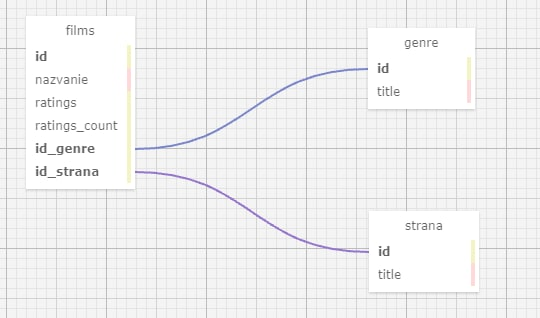

In [14]:
cursor = con.cursor()

Создание таблиц

In [15]:
cursor.execute("CREATE TABLE `films` (`id` INT, `nazvanie` VARCHAR(255), `ratings` DOUBLE, `id_genre` INT, `id_strana` INT, PRIMARY KEY (`id`, `id_genre`, `id_strana`))")
con.commit()

In [16]:
cursor.execute("CREATE TABLE `genre` (`id` INT, `title` VARCHAR(255), PRIMARY KEY (`id`))")
con.commit()

In [17]:
cursor.execute("CREATE TABLE `strana` (`id` INT, `title` VARCHAR(255), PRIMARY KEY (`id`))")
con.commit()

Подключение внешних ключей

In [18]:
cursor.execute("ALTER TABLE `films` ADD FOREIGN KEY (id_genre) REFERENCES `genre` (`id`)")
cursor.execute("ALTER TABLE `films` ADD FOREIGN KEY (id_strana) REFERENCES `strana` (`id`)")
con.commit()

Заполнение таблиц данными

In [19]:
dict_genre = {}
for i in range(100, 100 + len(list(set_genre))):
    cursor.execute("INSERT INTO `genre` (id,`title`) VALUES ('"+str(i)+"','"+list(set_genre)[i-100]+"')")
    dict_genre.update([(list(set_genre)[i-100], i)]) 
con.commit()

In [20]:
dict_strana = {}
for i in range(1000, 1000 + len(list(set_strana))):
    cursor.execute("INSERT INTO `strana` (id,`title`) VALUES ('"+str(i)+"','"+list(set_strana)[i-1000]+"')")
    dict_strana.update([(list(set_strana)[i-1000], i)]) 
con.commit()

In [22]:
for i in range(len(nazvanie)):
    cursor.execute("INSERT INTO `films` (`id`,`nazvanie`,`ratings`,`id_genre`,`id_strana`) VALUES ('"+str(i)+"','"+nazvanie[i]+"','"+str(ratings_list[i])+"', '"+str(dict_genre[genre_3[i]])+"','"+str(dict_strana[strana_3[i]])+"')")
con.commit()

In [25]:
cursor.execute("select * from films")
for rows in cursor:
    print(rows)

(0, ' Зеленая миля ', 8.9, 105, 1006)
(1, ' Побег из Шоушенка ', 8.9, 108, 1006)
(2, ' Властелин колец: Возвращение короля ', 8.8, 105, 1005)
(3, ' Властелин колец: Две крепости ', 8.8, 105, 1005)
(4, ' Властелин колец: Братство Кольца ', 8.8, 105, 1005)
(5, ' Король Лев ', 8.7, 100, 1006)
(6, ' Иван Васильевич меняет профессию ', 8.6, 110, 1002)
(7, ' Форрест Гамп ', 8.6, 108, 1006)
(8, ' Интерстеллар ', 8.6, 107, 1008)
(9, ' Тайна Коко ', 8.6, 100, 1006)
(10, ' Криминальное чтиво ', 8.6, 109, 1006)
(11, ' ВАЛЛ И ', 8.6, 100, 1006)
(12, ' 1+1 ', 8.6, 108, 1001)
(13, ' Карты, деньги, два ствола ', 8.6, 103, 1008)
(14, ' Начало ', 8.6, 107, 1006)
(15, ' Матрица ', 8.6, 107, 1006)
(16, ' Список Шиндлера ', 8.6, 108, 1006)
(17, ' Клаус ', 8.6, 100, 1007)
(18, ' Унесённые призраками ', 8.5, 101, 1000)
(19, ' Назад в будущее ', 8.5, 107, 1006)
(20, ' Джентльмены удачи ', 8.5, 110, 1002)
(21, ' Приключения Шерлока Холмса и доктора Ватсона: Собака Баскервилей ', 8.5, 104, 1002)
(22, ' Пираты 

Логи

[1, 19:56:47] Apply changes to DZ_2: Applying object changes ...
[1, 19:57:01] Apply changes to DZ_2: 
[2, 19:57:18] Apply changes to DZ_2: Applying object changes ...
[2, 19:57:24] Applying changes to dz_2...: 
[2, 19:57:24] : Changes applied to dz_2
[2, 19:57:28] Apply changes to DZ_2: Changes applied
[3, 19:58:04] Apply changes to cars: Applying object changes ...
[3, 19:58:08] Applying changes to cars...: 
[3, 19:58:21] Apply changes to cars: Error 1064: You have an error in your SQL syntax; check the manual that corresponds to your MySQL server version for the right syntax to use near ')' at line 2
SQL Statement:
CREATE TABLE `dz_2`.`cars` (
)


[4, 19:58:24] Apply changes to cars: Applying object changes ...
[4, 19:58:34] Applying changes to cars...: 
[4, 19:58:40] Apply changes to cars: Error 4028: A table must have at least one visible column.
SQL Statement:
CREATE TABLE `dz_2`.`cars`


[5, 20:00:44] Apply changes to cars: Applying object changes ...
[5, 20:00:49] Apply changes to cars: 
[6, 20:00:53] Apply changes to cars: Applying object changes ...
[6, 20:00:57] Applying changes to cars...: 
[6, 20:00:57] : Changes applied to cars
[6, 20:00:59] Apply changes to cars: Changes applied
[7, 20:01:18] Apply changes to cars: Applying object changes ...
[7, 20:01:18] Apply changes to cars: No changes detected
[8, 20:01:19] Apply changes to cars: Applying object changes ...
[8, 20:01:19] Apply changes to cars: No changes detected
[9, 20:01:20] Apply changes to cars: Applying object changes ...
[9, 20:01:20] Apply changes to cars: No changes detected
[10, 20:03:15] CREATE TABLE `dz_2`.`jopa` (
  `idcars` INT NULL)
ENGINE = InnoDB: Running...
[10, 20:03:15] CREATE TABLE `dz_2`.`jopa` (
  `idcars` INT NULL)
ENGINE = InnoDB: 0 row(s) affected
[11, 20:03:48] CREATE TABLE `dz_2`.`jopa` (
  `idcars` INT NULL)
ENGINE = InnoDB: Running...
[11, 20:03:48] CREATE TABLE `dz_2`.`jopa` (
  `idcars` INT NULL)
ENGINE = InnoDB: Error Code: 1050. Table 'jopa' already exists
[12, 20:04:41] DROP TABLE `dz_2`.`jopa`: Running...
[12, 20:04:41] DROP TABLE `dz_2`.`jopa`: 0 row(s) affected
[13, 20:28:45] Apply changes to cars: Applying object changes ...
[13, 20:28:45] Apply changes to cars: No changes detected
[14, 20:28:47] Apply changes to cars: Applying object changes ...
[14, 20:28:47] Apply changes to cars: No changes detected
[15, 20:30:38] Apply changes to cars1: Applying object changes ...
[15, 20:30:45] Apply changes to cars1: 
[16, 20:30:51] Apply changes to cars: Applying object changes ...
[16, 20:30:51] Apply changes to cars: No changes detected
[17, 20:30:52] Apply changes to cars: Applying object changes ...
[17, 20:30:52] Apply changes to cars: No changes detected
[18, 20:30:52] Apply changes to cars: Applying object changes ...
[18, 20:30:52] Apply changes to cars: No changes detected
[19, 20:30:55] Apply changes to cars: Applying object changes ...
[19, 20:30:55] Apply changes to cars: No changes detected
[20, 20:30:55] Apply changes to cars: Applying object changes ...
[20, 20:30:55] Apply changes to cars: No changes detected
[21, 20:30:55] Apply changes to cars: Applying object changes ...
[21, 20:30:55] Apply changes to cars: No changes detected
[22, 20:30:56] Apply changes to cars: Applying object changes ...
[22, 20:30:56] Apply changes to cars: No changes detected
[23, 20:30:56] Apply changes to cars: Applying object changes ...
[23, 20:30:56] Apply changes to cars: No changes detected
[24, 20:31:27] Apply changes to cars1: Applying object changes ...
[24, 20:33:44] Apply changes to cars1: 
[25, 20:33:49] CREATE TABLE `dz_2`.`cars1` (
  `idcars1` INT NOT NULL,
  PRIMARY KEY (`idcars1`)): Running...
[25, 20:33:49] CREATE TABLE `dz_2`.`cars1` (
  `idcars1` INT NOT NULL,
  PRIMARY KEY (`idcars1`)): 0 row(s) affected
[26, 20:46:02] SELECT version()
LIMIT 0, 1000
: Running...
[26, 20:46:02] SELECT version()
LIMIT 0, 1000
: Fetching...
[26, 20:46:02] SELECT version()
LIMIT 0, 1000
: 1 row(s) returned
[1, 21:08:13] use dz_2: Running...
[1, 21:08:13] use dz_2: 0 row(s) affected
[2, 21:08:13] insert into cars(idcars) value ('1'): Running...
[2, 21:08:13] insert into cars(idcars) value ('1'): 1 row(s) affected
[3, 21:08:29] select * from cars
LIMIT 0, 1000
: Running...
[3, 21:08:29] select * from cars
LIMIT 0, 1000
: Fetching...
[3, 21:08:29] select * from cars
LIMIT 0, 1000
: 1 row(s) returned
[4, 21:10:37] select * from cars
LIMIT 0, 1000
: Running...
[4, 21:10:37] select * from cars
LIMIT 0, 1000
: Fetching...
[4, 21:10:37] select * from cars
LIMIT 0, 1000
: 2 row(s) returned
[1, 15:54:17] use dz_2: Running...
[1, 15:54:17] use dz_2: 0 row(s) affected
[2, 15:54:17] drop "cars": Running...
[2, 15:54:17] drop "cars": Error Code: 1064. You have an error in your SQL syntax; check the manual that corresponds to your MySQL server version for the right syntax to use near '"cars"' at line 1
[3, 15:54:55] use dz_2: Running...
[3, 15:54:55] use dz_2: 0 row(s) affected
[4, 15:54:55] drop table cars: Running...
[5, 15:55:10] INTERRUPT: Running...
[5, 15:55:10] INTERRUPT: OK - Query cancelled
[4, 15:55:10] drop table cars: Error Code: 1317. Query execution was interrupted
[6, 15:55:13] use dz_2: Running...
[6, 15:55:13] use dz_2: 0 row(s) affected
[7, 15:55:13] drop table cars: Running...
[7, 15:55:43] drop table cars: Error Code: 2013. Lost connection to MySQL server during query
[8, 15:56:08] DROP TABLE `dz_2`.`cars`: Running...
[8, 15:56:38] DROP TABLE `dz_2`.`cars`: Error Code: 2013. Lost connection to MySQL server during query
[9, 15:56:38] DROP TABLE `dz_2`.`cars`: Running...
[9, 15:57:08] DROP TABLE `dz_2`.`cars`: Error Code: 2013. Lost connection to MySQL server during query
[1, 22:15:40] use dz_2: Running...
[1, 22:15:40] use dz_2: 0 row(s) affected
[2, 22:15:40] select * from wear
LIMIT 0, 1000
: Running...
[2, 22:15:40] select * from wear
LIMIT 0, 1000
: Fetching...
[2, 22:15:40] select * from wear
LIMIT 0, 1000
: 0 row(s) returned
[3, 22:21:10] use dz_2: Running...
[3, 22:21:10] use dz_2: 0 row(s) affected
[4, 22:21:10] select * from wear
LIMIT 0, 1000
: Running...
[4, 22:21:10] select * from wear
LIMIT 0, 1000
: Fetching...
[4, 22:21:10] select * from wear
LIMIT 0, 1000
: 0 row(s) returned
[5, 22:24:23] use dz_2: Running...
[5, 22:24:23] use dz_2: 0 row(s) affected
[6, 22:24:23] select * from wear
LIMIT 0, 1000
: Running...
[6, 22:24:23] select * from wear
LIMIT 0, 1000
: Fetching...
[6, 22:24:23] select * from wear
LIMIT 0, 1000
: 59 row(s) returned
[7, 22:30:29] use dz_2: Running...
[7, 22:30:29] use dz_2: 0 row(s) affected
[8, 22:30:29] select * from wear
LIMIT 0, 1000
: Running...
[8, 22:30:29] select * from wear
LIMIT 0, 1000
: Fetching...
[8, 22:30:29] select * from wear
LIMIT 0, 1000
: 106 row(s) returned
[9, 22:30:55] use dz_2: Running...
[9, 22:30:55] use dz_2: 0 row(s) affected
[10, 22:30:55] select * from wear
LIMIT 0, 1000
: Running...
[10, 22:30:55] select * from wear
LIMIT 0, 1000
: Fetching...
[10, 22:30:55] select * from wear
LIMIT 0, 1000
: 0 row(s) returned
[11, 23:12:43] use dz_2: Running...
[11, 23:12:43] use dz_2: 0 row(s) affected
[12, 23:12:43] select * from wear
LIMIT 0, 1000
: Running...
[12, 23:12:43] select * from wear
LIMIT 0, 1000
: Fetching...
[12, 23:12:43] select * from wear
LIMIT 0, 1000
: 59 row(s) returned
[13, 23:17:08] EXPLAIN select * from wear: Executing 
[13, 23:17:08] EXPLAIN select * from wear: OK
[14, 23:17:08] EXPLAIN FORMAT=JSON select * from wear: Executing 
[14, 23:17:08] EXPLAIN FORMAT=JSON select * from wear: OK
[1, 15:45:16] select * from wear
LIMIT 0, 1000
: Running...
[1, 15:45:16] select * from wear
LIMIT 0, 1000
: Fetching...
[1, 15:45:16] select * from wear
LIMIT 0, 1000
: 59 row(s) returned
[1, 23:39:48] DROP TABLE `dz_2`.`seasons`: Running...
[1, 23:39:48] DROP TABLE `dz_2`.`seasons`: 0 row(s) affected
[2, 23:39:51] DROP TABLE `dz_2`.`sex`: Running...
[2, 23:39:51] DROP TABLE `dz_2`.`sex`: 0 row(s) affected
[3, 23:39:54] DROP TABLE `dz_2`.`wear`: Running...
[3, 23:39:54] DROP TABLE `dz_2`.`wear`: 0 row(s) affected
[1, 13:18:12] select * from films
LIMIT 0, 1000
: Running...
[1, 13:18:12] select * from films
LIMIT 0, 1000
: Fetching...
[1, 13:18:12] select * from films
LIMIT 0, 1000
: 0 row(s) returned
[2, 13:39:27] select * from films
LIMIT 0, 1000
: Running...
[2, 13:39:27] select * from films
LIMIT 0, 1000
: Fetching...
[2, 13:39:27] select * from films
LIMIT 0, 1000
: 0 row(s) returned
[3, 13:54:17] select * from genre
LIMIT 0, 1000
: Running...
[3, 13:54:17] select * from genre
LIMIT 0, 1000
: Fetching...
[3, 13:54:17] select * from genre
LIMIT 0, 1000
: 19 row(s) returned
[4, 13:55:00] select * from genre
LIMIT 0, 1000
: Running...
[4, 13:55:00] select * from genre
LIMIT 0, 1000
: Fetching...
[4, 13:55:00] select * from genre
LIMIT 0, 1000
: 39 row(s) returned
[5, 13:56:02] DELETE FROM genre: Running...
[5, 13:56:02] DELETE FROM genre: Error Code: 1175. You are using safe update mode and you tried to update a table without a WHERE that uses a KEY column. 
To disable safe mode, toggle the option in Preferences -> SQL Editor and reconnect.
[6, 13:56:07] select * from genre
LIMIT 0, 1000
: Running...
[6, 13:56:07] select * from genre
LIMIT 0, 1000
: Fetching...
[6, 13:56:07] select * from genre
LIMIT 0, 1000
: 39 row(s) returned
[7, 13:56:23] select * from genre
LIMIT 0, 1000
: Running...
[7, 13:56:23] select * from genre
LIMIT 0, 1000
: Fetching...
[7, 13:56:23] select * from genre
LIMIT 0, 1000
: 39 row(s) returned
[8, 13:57:08] select * from genre
LIMIT 0, 1000
: Running...
[8, 13:57:08] select * from genre
LIMIT 0, 1000
: Fetching...
[8, 13:57:08] select * from genre
LIMIT 0, 1000
: 0 row(s) returned
[9, 13:57:20] select * from genre
LIMIT 0, 1000
: Running...
[9, 13:57:20] select * from genre
LIMIT 0, 1000
: Fetching...
[9, 13:57:20] select * from genre
LIMIT 0, 1000
: 19 row(s) returned
[10, 13:57:43] DROP TABLE `dz_2`.`films`: Running...
[10, 13:57:43] DROP TABLE `dz_2`.`films`: 0 row(s) affected
[11, 13:57:47] DROP TABLE `dz_2`.`genre`: Running...
[11, 13:57:47] DROP TABLE `dz_2`.`genre`: 0 row(s) affected
[12, 13:57:50] DROP TABLE `dz_2`.`strana`: Running...
[12, 13:57:50] DROP TABLE `dz_2`.`strana`: 0 row(s) affected
[13, 13:58:06] select * from genre
LIMIT 0, 1000
: Running...
[13, 13:58:06] select * from genre
LIMIT 0, 1000
: Fetching...
[13, 13:58:06] select * from genre
LIMIT 0, 1000
: 0 row(s) returned
[14, 13:58:14] DROP TABLE `dz_2`.`films`: Running...
[14, 13:58:14] DROP TABLE `dz_2`.`films`: 0 row(s) affected
[15, 13:58:16] DROP TABLE `dz_2`.`genre`: Running...
[15, 13:58:16] DROP TABLE `dz_2`.`genre`: 0 row(s) affected
[16, 13:58:19] DROP TABLE `dz_2`.`strana`: Running...
[16, 13:58:19] DROP TABLE `dz_2`.`strana`: 0 row(s) affected
[17, 13:59:24] select * from genre
LIMIT 0, 1000
: Running...
[17, 13:59:24] select * from genre
LIMIT 0, 1000
: Fetching...
[17, 13:59:24] select * from genre
LIMIT 0, 1000
: 19 row(s) returned
[18, 14:01:34] select * from strana
LIMIT 0, 1000
: Running...
[18, 14:01:34] select * from strana
LIMIT 0, 1000
: Fetching...
[18, 14:01:34] select * from strana
LIMIT 0, 1000
: 11 row(s) returned
[19, 14:14:04] DROP TABLE `dz_2`.`films`: Running...
[19, 14:14:34] DROP TABLE `dz_2`.`films`: Error Code: 2013. Lost connection to MySQL server during query
[20, 14:14:34] DROP TABLE `dz_2`.`genre`: Running...
[21, 14:14:54] INTERRUPT: Running...
[21, 14:14:54] INTERRUPT: OK - Query cancelled
[20, 14:14:54] DROP TABLE `dz_2`.`genre`: Error Code: 1317. Query execution was interrupted
[22, 14:14:54] DROP TABLE `dz_2`.`strana`: Running...
[23, 14:14:57] INTERRUPT: Running...
[23, 14:14:57] INTERRUPT: OK - Query cancelled
[24, 14:14:57] DROP TABLE `dz_2`.`films`: Running...
[25, 14:14:58] INTERRUPT: Running...
[25, 14:14:58] INTERRUPT: OK - Query cancelled
[26, 14:14:58] DROP TABLE `dz_2`.`films`: Running...
[27, 14:14:58] INTERRUPT: Running...
[27, 14:14:58] INTERRUPT: OK - Query cancelled
[1, 14:15:16] DROP TABLE `dz_2`.`films`: Running...
[2, 14:15:22] INTERRUPT: Running...
[1, 14:15:22] DROP TABLE `dz_2`.`films`: Error Code: 1317. Query execution was interrupted
[2, 14:15:22] INTERRUPT: OK - Query cancelled
[1, 14:17:59] DROP TABLE `dz_2`.`genre`: Running...
[1, 14:17:59] DROP TABLE `dz_2`.`genre`: 0 row(s) affected
[2, 14:18:02] DROP TABLE `dz_2`.`strana`: Running...
[2, 14:18:02] DROP TABLE `dz_2`.`strana`: 0 row(s) affected
[3, 14:18:34] select * from strana
LIMIT 0, 1000
: Running...
[3, 14:18:34] select * from strana
LIMIT 0, 1000
: Fetching...
[3, 14:18:34] select * from strana
LIMIT 0, 1000
: 11 row(s) returned
[4, 14:18:38] DROP TABLE `dz_2`.`films`: Running...
[4, 14:18:38] DROP TABLE `dz_2`.`films`: 0 row(s) affected
[5, 14:18:41] DROP TABLE `dz_2`.`genre`: Running...
[5, 14:18:41] DROP TABLE `dz_2`.`genre`: 0 row(s) affected
[6, 14:18:44] DROP TABLE `dz_2`.`strana`: Running...
[6, 14:18:44] DROP TABLE `dz_2`.`strana`: 0 row(s) affected
[7, 14:19:30] select * from films
LIMIT 0, 1000
: Running...
[7, 14:19:30] select * from films
LIMIT 0, 1000
: Fetching...
[7, 14:19:30] select * from films
LIMIT 0, 1000
: 0 row(s) returned
[8, 14:28:01] DROP TABLE `dz_2`.`films`: Running...
[8, 14:28:01] DROP TABLE `dz_2`.`films`: 0 row(s) affected
[9, 14:28:05] DROP TABLE `dz_2`.`genre`: Running...
[9, 14:28:05] DROP TABLE `dz_2`.`genre`: 0 row(s) affected
[10, 14:28:09] DROP TABLE `dz_2`.`strana`: Running...
[10, 14:28:09] DROP TABLE `dz_2`.`strana`: 0 row(s) affected
[11, 14:31:52] select * from films
LIMIT 0, 1000
: Running...
[11, 14:31:52] select * from films
LIMIT 0, 1000
: Fetching...
[11, 14:31:52] select * from films
LIMIT 0, 1000
: 0 row(s) returned
[12, 14:31:57] DROP TABLE `dz_2`.`films`: Running...
[13, 14:32:05] INTERRUPT: Running...
[13, 14:32:05] INTERRUPT: OK - Query cancelled
[12, 14:32:05] DROP TABLE `dz_2`.`films`: Error Code: 1317. Query execution was interrupted
[1, 14:32:36] DROP TABLE `dz_2`.`films`: Running...
[2, 14:32:49] INTERRUPT: Running...
[2, 14:32:49] INTERRUPT: OK - Query cancelled
[1, 14:32:49] DROP TABLE `dz_2`.`films`: Error Code: 1317. Query execution was interrupted
[1, 14:35:42] select * from genre
LIMIT 0, 1000
: Running...
[1, 14:35:42] select * from genre
LIMIT 0, 1000
: Fetching...
[1, 14:35:42] select * from genre
LIMIT 0, 1000
: 19 row(s) returned
[1, 14:36:26] DROP TABLE `dz_2`.`genre`: Running...
[1, 14:36:26] DROP TABLE `dz_2`.`genre`: 0 row(s) affected
[2, 14:36:29] DROP TABLE `dz_2`.`strana`: Running...
[2, 14:36:29] DROP TABLE `dz_2`.`strana`: 0 row(s) affected
[1, 15:00:12] select * from films
LIMIT 0, 1000
: Running...
[1, 15:00:12] select * from films
LIMIT 0, 1000
: Fetching...
[1, 15:00:12] select * from films
LIMIT 0, 1000
: 0 row(s) returned
[2, 15:01:14] select * from films
LIMIT 0, 1000
: Running...
[2, 15:01:14] select * from films
LIMIT 0, 1000
: Fetching...
[2, 15:01:15] select * from films
LIMIT 0, 1000
: 0 row(s) returned
[3, 15:01:18] DROP TABLE `dz_2`.`films`: Running...
[3, 15:01:18] DROP TABLE `dz_2`.`films`: 0 row(s) affected
[4, 15:01:21] DROP TABLE `dz_2`.`genre`: Running...
[4, 15:01:21] DROP TABLE `dz_2`.`genre`: 0 row(s) affected
[5, 15:01:24] DROP TABLE `dz_2`.`strana`: Running...
[5, 15:01:24] DROP TABLE `dz_2`.`strana`: 0 row(s) affected
[6, 15:38:14] select * from films
LIMIT 0, 1000
: Running...
[6, 15:38:14] select * from films
LIMIT 0, 1000
: Fetching...
[6, 15:38:14] select * from films
LIMIT 0, 1000
: 0 row(s) returned
[7, 15:38:18] select * from genre
LIMIT 0, 1000
: Running...
[7, 15:38:18] select * from genre
LIMIT 0, 1000
: Fetching...
[7, 15:38:18] select * from genre
LIMIT 0, 1000
: 19 row(s) returned
[8, 15:38:23] select * from strana
LIMIT 0, 1000
: Running...
[8, 15:38:23] select * from strana
LIMIT 0, 1000
: Fetching...
[8, 15:38:23] select * from strana
LIMIT 0, 1000
: 9 row(s) returned
[1, 00:07:53] select * from genre
LIMIT 0, 1000
: Running...
[1, 00:07:53] select * from genre
LIMIT 0, 1000
: Fetching...
[1, 00:07:53] select * from genre
LIMIT 0, 1000
: 19 row(s) returned
[2, 00:09:46] DROP TABLE `dz_2`.`films`: Running...
[3, 00:09:57] INTERRUPT: Running...
[3, 00:09:57] INTERRUPT: OK - Query cancelled
[2, 00:09:57] DROP TABLE `dz_2`.`films`: Error Code: 1317. Query execution was interrupted
[4, 00:10:06] DROP TABLE `dz_2`.`films`: Running...
[5, 00:10:09] INTERRUPT: Running...
[5, 00:10:09] INTERRUPT: OK - Query cancelled
[1, 00:10:53] DROP TABLE `dz_2`.`films`: Running...
[1, 00:11:24] DROP TABLE `dz_2`.`films`: Error Code: 2013. Lost connection to MySQL server during query
[1, 00:12:30] DROP TABLE `dz_2`.`genre`: Running...
[1, 00:12:30] DROP TABLE `dz_2`.`genre`: 0 row(s) affected
[2, 00:12:33] DROP TABLE `dz_2`.`strana`: Running...
[2, 00:12:33] DROP TABLE `dz_2`.`strana`: 0 row(s) affected
[3, 00:29:22] select * from films
LIMIT 0, 1000
: Running...
[3, 00:29:22] select * from films
LIMIT 0, 1000
: Fetching...
[3, 00:29:22] select * from films
LIMIT 0, 1000
: 50 row(s) returned
[4, 00:51:33] select * from films
LIMIT 0, 1000
: Running...
[4, 00:51:34] select * from films
LIMIT 0, 1000
: Fetching...
[4, 00:51:34] select * from films
LIMIT 0, 1000
: 50 row(s) returned
[1, 15:09:50] select * from films
LIMIT 0, 1000
: Running...
[1, 15:09:50] select * from films
LIMIT 0, 1000
: Fetching...
[1, 15:09:50] select * from films
LIMIT 0, 1000
: 50 row(s) returned
[2, 15:10:15] select * from genre
LIMIT 0, 1000
: Running...
[2, 15:10:15] select * from genre
LIMIT 0, 1000
: Fetching...
[2, 15:10:15] select * from genre
LIMIT 0, 1000
: 13 row(s) returned
[3, 15:10:48] DROP TABLE `dz_2`.`films`: Running...
[3, 15:10:48] DROP TABLE `dz_2`.`films`: 0 row(s) affected
[4, 15:10:52] DROP TABLE `dz_2`.`genre`: Running...
[4, 15:10:52] DROP TABLE `dz_2`.`genre`: 0 row(s) affected
[5, 15:10:54] DROP TABLE `dz_2`.`strana`: Running...
[5, 15:10:54] DROP TABLE `dz_2`.`strana`: 0 row(s) affected
[1, 15:11:57] select * from films
LIMIT 0, 1000
: Running...
[1, 15:11:57] select * from films
LIMIT 0, 1000
: Fetching...
[1, 15:11:57] select * from films
LIMIT 0, 1000
: 50 row(s) returned
